# Prueba Técnica Arkon

Autor: Juan Carlos Hernández Rangel<br>
Desarrollo: 30-noviembre-2022

## Problema

En Los Ángeles existe un sistema compartido de bicicletas que brinda datos anónimos acerca
del uso del servicio. La tabla que se proporciona contiene el histórico de viajes que se han
realizado desde 2016 y contiene una columna que es de particular interés y que se buscará
analizar a más profundidad: Passholder_type. 

## Metodología

### Funciones

In [1]:
def generar_estadisticas_basicas(serie):
    '''
    Función para obtener estadísticas básicas de la serie
    '''
    sesgo = skew(serie)
    kurto = kurtosis(serie)
    estadisticas_basicas = pd.DataFrame(serie.describe())
    estadisticas_basicas.loc["skew"] = sesgo
    estadisticas_basicas.loc["kurtosis"] = kurto
    return estadisticas_basicas

def generar_mapa_calor(pivote, estacion):
    plt.figure(figsize=(13, 8))
    plt.title(f"Mapa de Calor de los Horarios para Monthly Pass estación {estacion}", size=14)
    sns.heatmap(pivote);
    
def generar_mapa_calor_2(pivote_inicio, pivote_fin, estacion):
    fig, axes = plt.subplots(1, 2, figsize=(13, 5), tight_layout=True)
    sns.heatmap(pivote_inicio, ax=axes[0])
    sns.heatmap(pivote_fin, ax=axes[1])
    
    axes[0].set_title(f"Horario Inicio para Estacion {estacion}", size=12)
    axes[1].set_title(f"Horario Fin para Estacion {estacion}", size=12)
    axes[0].set_xlabel("Minutos")
    axes[1].set_xlabel("Minutos")
    axes[0].set_ylabel("Horas")
    axes[1].set_ylabel("Horas");

### Importar librerías

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gp

from geopandas import GeoDataFrame
from shapely.geometry import Point
from scipy.stats import skew, kurtosis

### Importar conjunto de datos

In [3]:
path_entrenamiento = '../Data/train_set.csv'
dataFrame = pd.read_csv(path_entrenamiento, low_memory=False)

### Características del conjunto de datos

In [4]:
# Primeras 3 filas
dataFrame.head(3)

,trip_id,duration,start_time,end_time,start_lat,start_lon,end_lat,end_lon,bike_id,plan_duration,trip_route_category,passholder_type,start_station,end_station
0,101750280,35,2018-08-07 11:20:00,2018-08-07 11:55:00,33.748920,-118.275192,33.748920,-118.275192,06530,1.0,Round Trip,Walk-up,4127,4127
1,46560345,32,9/17/2017 17:51,9/17/2017 18:23,34.035679,-118.270813,34.047749,-118.243172,6683,0.0,One Way,Walk-up,3057,3062
2,120016336,6,2019-04-22 09:22:00,2019-04-22 09:28:00,34.046070,-118.233093,34.047749,-118.243172,06710,30.0,One Way,Monthly Pass,3022,3062


In [5]:
filas, columnas = dataFrame.shape
print(f"Total de filas: {filas}")
print(f"Total de columnas: {columnas}")

Total de filas: 700000
Total de columnas: 14


In [6]:
# Tipo de dato por columna
dataFrame.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 700000 entries, 0 to 699999
Data columns (total 14 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   trip_id              700000 non-null  int64  
 1   duration             700000 non-null  int64  
 2   start_time           700000 non-null  object 
 3   end_time             700000 non-null  object 
 4   start_lat            694437 non-null  float64
 5   start_lon            694437 non-null  float64
 6   end_lat              681426 non-null  float64
 7   end_lon              681426 non-null  float64
 8   bike_id              700000 non-null  object 
 9   plan_duration        699792 non-null  float64
 10  trip_route_category  700000 non-null  object 
 11  passholder_type      697424 non-null  object 
 12  start_station        700000 non-null  int64  
 13  end_station          700000 non-null  int64  
dtypes: float64(5), int64(4), object(5)
memory usage: 74.8+ MB


### Análisis Exploratorio de los Datos

#### Trip_id

In [7]:
# ¿El trip_id es único?
# Tenemos un total de 700,000 ids únicos, lo que nos índica que no tenemos inconsistencias en esa columna
# Al mismo tiempo, esta columna no es de interés para nuestro modelo. El ID no es más que un identificador
# no una variable determinante.
dataFrame["trip_id"].nunique()

700000

#### Duration

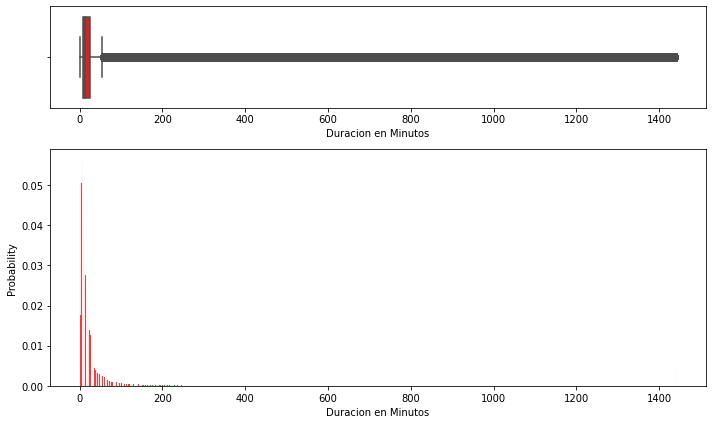

In [8]:
# ¿Cómo se comporta la variable "duration"?
# Una variable con una cola MUY larga, lo que nos indica que tenemos valores muy extremos.
# Se tendrá que hacer un análisis de datos atipicos o bien aplicar algún tipo de transformación.
fig, axes = plt.subplots(2, 1, figsize=(10, 6), tight_layout=True, gridspec_kw={'height_ratios':[0.6, 1.4]})
sns.boxplot(x=dataFrame["duration"], color='red', ax=axes[0])
sns.histplot(x=dataFrame["duration"], stat="probability", color='red', ax=axes[1])

axes[0].set_xlabel("Duracion en Minutos")
axes[1].set_xlabel("Duracion en Minutos");

In [9]:
# Estadísticas básicas de la variable
# Con los resultados, la estadística "skew" nos muestra que tenemos más peso en la cola izquierda de la distribución
# y con los resultados de la "kurtosis" vemos una distribución leptocurtica.
estadisticas_duration = generar_estadisticas_basicas(dataFrame["duration"])
estadisticas_duration

,duration
count,700000.000000
mean,37.084979
std,125.302510
min,1.000000
25%,7.000000
50%,13.000000
75%,26.000000
max,1440.000000
skew,8.996609
kurtosis,89.217192


#### Start_Time

In [10]:
# Lo primero que podemos notar es que la fecha no esta en el mismo formato, esto puede causar bastantes problemas.
# Estandarizaremos estos datos primero
dataFrame["start_time"].head(3)

0    2018-08-07 11:20:00
1        9/17/2017 17:51
2    2019-04-22 09:22:00
Name: start_time, dtype: object

In [11]:
dataFrame["start_time"] = pd.to_datetime(dataFrame["start_time"], infer_datetime_format=True)

In [12]:
dataFrame["start_time"].head()

0   2018-08-07 11:20:00
1   2017-09-17 17:51:00
2   2019-04-22 09:22:00
3   2019-09-22 11:27:00
4   2020-01-31 17:11:00
Name: start_time, dtype: datetime64[ns]

In [13]:
# Dado que la fecha por si sola es díficil de analizar y manipular lo que se puede hacer es crear más variables donde
# se desglosa la fecha en sus componentes principales: Día, Mes, Año, Hora y Minuto
dataFrame["start_time_day"] = dataFrame["start_time"].dt.day
dataFrame["start_time_month"] = dataFrame["start_time"].dt.month
dataFrame["start_time_year"] = dataFrame["start_time"].dt.year
dataFrame["start_time_hour"] = dataFrame["start_time"].dt.hour
dataFrame["start_time_minute"] = dataFrame["start_time"].dt.minute

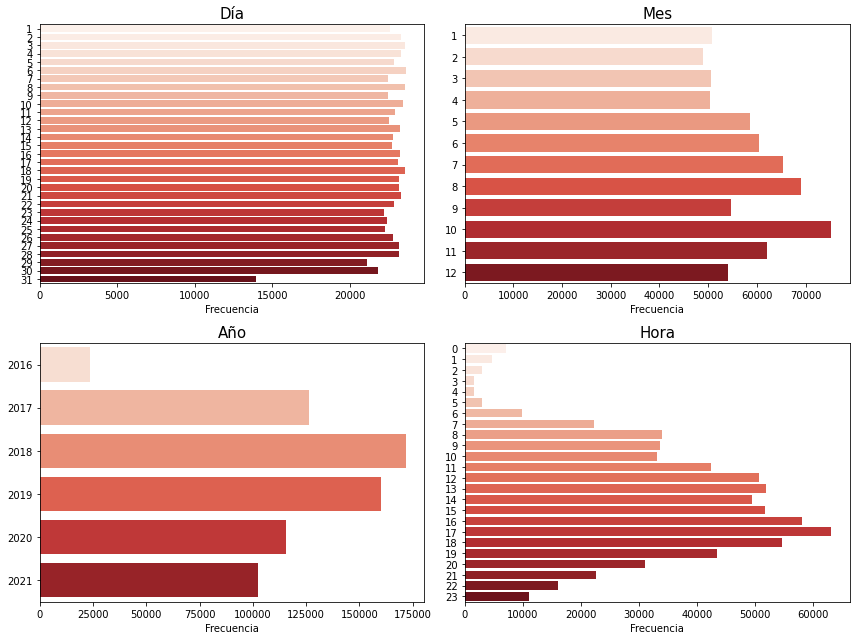

In [14]:
# Gráficos
# Los resultados son interesantes, se podía esperar que los datos del día tuvieran una distribución uniforme
# y en efecto así fue.
# Los resultados más llamativos son para Meses, Año y Hora.
# Podemos notar que el mes de Octubre es donde se han tenido más viajes
# Al igual para el año, el 2018 fue donde se tuvieron más viajes, lo cual resulta normal dado que los años siguientes
# inicio la pandemia de COVID
# Y por último, vemos que la hora más concurrida son las 17 hrs, esto se puede deber a que es la hora donde
# la mayor parte de los trabajadores dejan las oficinas.
fig, axes = plt.subplots(2, 2, figsize=(12, 9), tight_layout=True)
flatten_axes = axes.flatten()
agrupado_st_dia = dataFrame["start_time_day"].value_counts().sort_index()
agrupado_st_mes = dataFrame["start_time_month"].value_counts().sort_index()
agrupado_st_ano = dataFrame["start_time_year"].value_counts().sort_index()
agrupado_st_hora = dataFrame["start_time_hour"].value_counts().sort_index()

sns.barplot(y=agrupado_st_dia.index.astype(str), x=agrupado_st_dia, palette="Reds", ax=flatten_axes[0])
sns.barplot(y=agrupado_st_mes.index.astype(str), x=agrupado_st_mes, palette="Reds", ax=flatten_axes[1])
sns.barplot(y=agrupado_st_ano.index.astype(str), x=agrupado_st_ano, palette="Reds", ax=flatten_axes[2])
sns.barplot(y=agrupado_st_hora.index.astype(str), x=agrupado_st_hora, palette="Reds", ax=flatten_axes[3])

flatten_axes[0].set_xlabel("Frecuencia")
flatten_axes[1].set_xlabel("Frecuencia")
flatten_axes[2].set_xlabel("Frecuencia")
flatten_axes[3].set_xlabel("Frecuencia")

flatten_axes[0].set_title("Día", size=15)
flatten_axes[1].set_title("Mes", size=15)
flatten_axes[2].set_title("Año", size=15)
flatten_axes[3].set_title("Hora", size=15);

#### End_Time

In [15]:
# Al igual que con la variable "start_time", en la variable "end_time" también tenemos una inconsistencia en el 
# formato de las fechas.
dataFrame["end_time"].head(3)

0    2018-08-07 11:55:00
1        9/17/2017 18:23
2    2019-04-22 09:28:00
Name: end_time, dtype: object

In [16]:
dataFrame["end_time"] = pd.to_datetime(dataFrame["end_time"], infer_datetime_format=True)

In [17]:
dataFrame["end_time"].head()

0   2018-08-07 11:55:00
1   2017-09-17 18:23:00
2   2019-04-22 09:28:00
3   2019-09-22 13:45:00
4   2020-01-31 17:25:00
Name: end_time, dtype: datetime64[ns]

In [18]:
# Dado que la fecha por si sola es díficil de analizar y manipular lo que se puede hacer es crear más variables donde
# se desglosa la fecha en sus componentes principales: Día, Mes, Año, Hora y Minuto
dataFrame["end_time_day"] = dataFrame["end_time"].dt.day
dataFrame["end_time_month"] = dataFrame["end_time"].dt.month
dataFrame["end_time_year"] = dataFrame["end_time"].dt.year
dataFrame["end_time_hour"] = dataFrame["end_time"].dt.hour
dataFrame["end_time_minute"] = dataFrame["end_time"].dt.minute

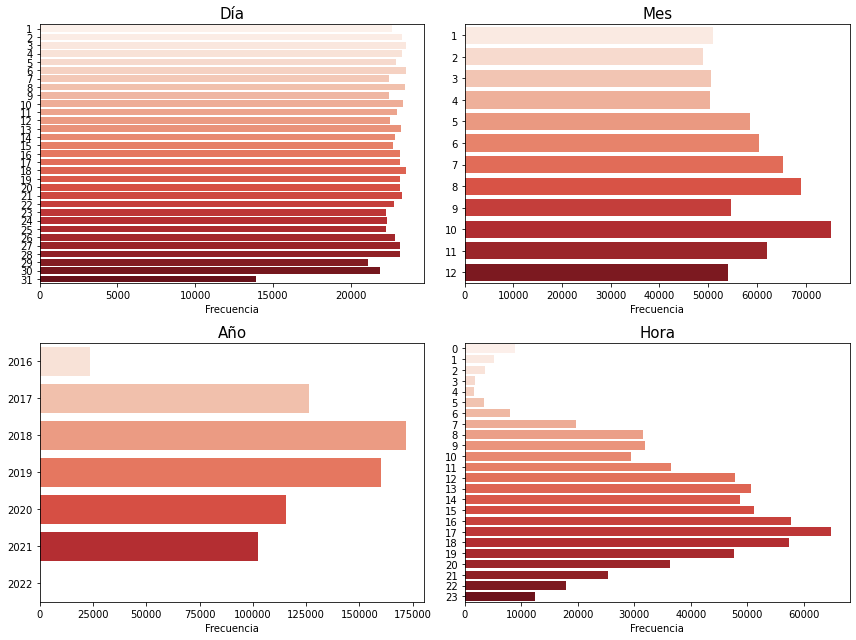

In [19]:
# Gráficos
# Los resultados son interesantes, se podía esperar que los datos del día tuvieran una distribución uniforme
# y en efecto así fue.
# Los resultados más llamativos son para Meses, Año y Hora.
# Podemos notar que el mes de Octubre es donde se han tenido más viajes
# Al igual para el año, el 2018 fue donde se tuvieron más viajes, lo cual resulta normal dado que los años siguientes
# inicio la pandemia de COVID
# Y por último, vemos que la hora más concurrida son las 17 hrs, esto se puede deber a que es la hora donde
# la mayor parte de los trabajadores dejan las oficinas. Dado que los viajes (suposición) en bicicleta no duran más
# de una hora, suena razonable que la hora de finalizar su viaje sea en la misma hora
fig, axes = plt.subplots(2, 2, figsize=(12, 9), tight_layout=True)
flatten_axes = axes.flatten()
agrupado_ed_dia = dataFrame["end_time_day"].value_counts().sort_index()
agrupado_ed_mes = dataFrame["end_time_month"].value_counts().sort_index()
agrupado_ed_ano = dataFrame["end_time_year"].value_counts().sort_index()
agrupado_ed_hora = dataFrame["end_time_hour"].value_counts().sort_index()

sns.barplot(y=agrupado_ed_dia.index.astype(str), x=agrupado_ed_dia, palette="Reds", ax=flatten_axes[0])
sns.barplot(y=agrupado_ed_mes.index.astype(str), x=agrupado_ed_mes, palette="Reds", ax=flatten_axes[1])
sns.barplot(y=agrupado_ed_ano.index.astype(str), x=agrupado_ed_ano, palette="Reds", ax=flatten_axes[2])
sns.barplot(y=agrupado_ed_hora.index.astype(str), x=agrupado_ed_hora, palette="Reds", ax=flatten_axes[3])

flatten_axes[0].set_xlabel("Frecuencia")
flatten_axes[1].set_xlabel("Frecuencia")
flatten_axes[2].set_xlabel("Frecuencia")
flatten_axes[3].set_xlabel("Frecuencia")

flatten_axes[0].set_title("Día", size=15)
flatten_axes[1].set_title("Mes", size=15)
flatten_axes[2].set_title("Año", size=15)
flatten_axes[3].set_title("Hora", size=15);

#### Start_lat | Start_lon | End_lat | End_lon

In [20]:
# Haremos un análisis de estas variables en conjunto
# Estas variables cuentan con valores nulos, obtendremos una proporción de estos
# Afortunadamente no tenemos un numero de datos vacíos grande. Dado el total de datos (700,000), podríamos eliminar
# este conjunto de datos vacíos y no perderíamos tanta información.
total_na_valores = pd.DataFrame(dataFrame[['start_lat','start_lon','end_lat','end_lon']].isna().sum())
total_na_porcentaje = pd.DataFrame((dataFrame[['start_lat','start_lon','end_lat','end_lon']].isna().sum()*100/dataFrame.shape[0]).round(3))
total_na_lat_lon = pd.concat([total_na_valores, total_na_porcentaje], axis=1)
total_na_lat_lon.columns = ["Total-Valores-Nulos", "Proporcion-Valores-Nulos"]
total_na_lat_lon

,Total-Valores-Nulos,Proporcion-Valores-Nulos
start_lat,5563,0.795
start_lon,5563,0.795
end_lat,18574,2.653
end_lon,18574,2.653


In [21]:
# Como podemos notar por este resultado, la captura de la latitud y de la longitud al inicio no se dio para el 
# mismo conjunto de datos, esto nos puede hablar de ciertos problemas que hubo al momento de la captura de la
# información. De igual forma, para algunos de estos datos no se tienen los datos de finalización.
dataFrame[(dataFrame["start_lat"].isna()) & (dataFrame["start_lon"].isna())].shape

(5563, 24)

In [22]:
dataFrame[(dataFrame["start_lat"].isna()) & (dataFrame["start_lon"].isna())]["bike_id"].value_counts()[:5]

15941    39
15759    34
15630    26
15927    26
15953    25
Name: bike_id, dtype: int64

In [23]:
dataFrame[(dataFrame["end_lat"].isna()) & (dataFrame["end_lon"].isna())]["bike_id"].value_counts()[:5]

18954    60
15941    47
15759    42
15927    36
19115    36
Name: bike_id, dtype: int64

Lo que vemos arriba serían las 5 bicicletas que presentan más problemas para registrar los datos de inicio y de fin. Como podemos notar, las bicicletas con el id __15941__ y __15759__ son las que presentan mayores problemas en registrar estos datos. __Esta información es útil ya que valdría la pena hacer una revisión a las mismas__.

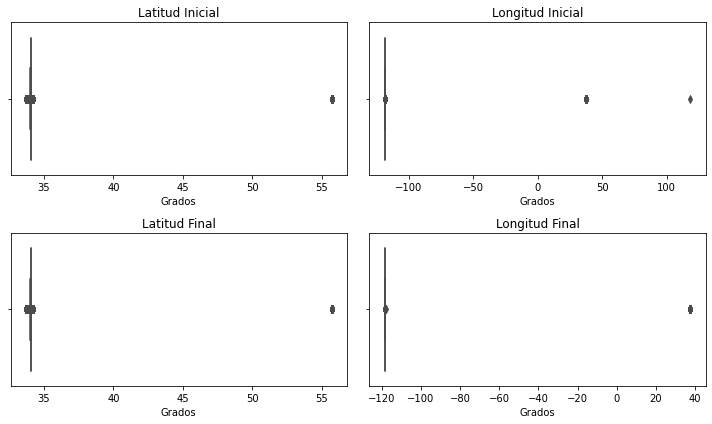

In [24]:
# Gráficas
# Como podemos notar en los diagramas de caja y bigote, tenemos unos datos que se podrían considerar atípicos.
# Hagamos un filtro a estas variables y veamos si en efecto son pocos los datos atípicos

fig, axes = plt.subplots(2, 2, figsize=(10, 6), tight_layout=True)
flatten_axes = axes.flatten()
sns.boxplot(x=dataFrame["start_lat"], color='red', ax=flatten_axes[0])
sns.boxplot(x=dataFrame["start_lon"], color='red', ax=flatten_axes[1])
sns.boxplot(x=dataFrame["end_lat"], color='red', ax=flatten_axes[2])
sns.boxplot(x=dataFrame["end_lon"], color='red', ax=flatten_axes[3])

flatten_axes[0].set_xlabel("Grados")
flatten_axes[1].set_xlabel("Grados")
flatten_axes[2].set_xlabel("Grados")
flatten_axes[3].set_xlabel("Grados")

flatten_axes[0].set_title("Latitud Inicial", size=12)
flatten_axes[1].set_title("Longitud Inicial", size=12)
flatten_axes[2].set_title("Latitud Final", size=12)
flatten_axes[3].set_title("Longitud Final", size=12);

In [25]:
valores_st_lat_50 = dataFrame[dataFrame["start_lat"] > 50].shape[0]
valores_st_lon_0 = dataFrame[dataFrame["start_lon"] > 0].shape[0]
valores_ed_lat_50 = dataFrame[dataFrame["end_lat"] > 50].shape[0]
valores_ed_lon_0 = dataFrame[dataFrame["end_lon"] > 0].shape[0]

print(f"Total de valores con una latitud inicial mayor a 50: {valores_st_lat_50}")
print(f"Total de valores con una longitud inicial mayor a 0: {valores_st_lon_0}")
print(f"Total de valores con una latitud final mayor a 50: {valores_ed_lat_50}")
print(f"Total de valores con una longitud final mayor a 0: {valores_ed_lon_0}")

Total de valores con una latitud inicial mayor a 50: 153
Total de valores con una longitud inicial mayor a 0: 154
Total de valores con una latitud final mayor a 50: 127
Total de valores con una longitud final mayor a 0: 127


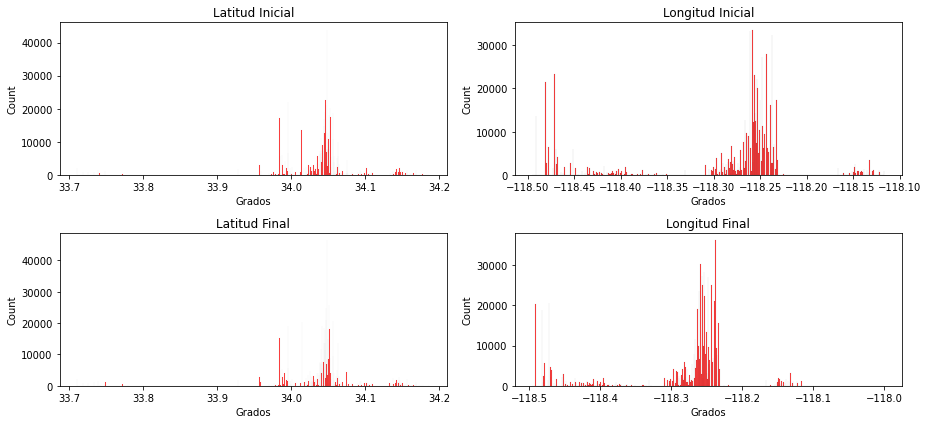

In [26]:
# Vamos a ver la distribución de estas variables sin estos valores que podríamos considerar atípicos
fig, axes = plt.subplots(2, 2, figsize=(13, 6), tight_layout=True)
flatten_axes = axes.flatten()
sns.histplot(dataFrame[dataFrame["start_lat"] < 50]['start_lat'], color='red', ax=flatten_axes[0])
sns.histplot(dataFrame[dataFrame["start_lon"] < 0]['start_lon'], color='red', ax=flatten_axes[1])
sns.histplot(dataFrame[dataFrame["end_lat"] < 50]['end_lat'], color='red', ax=flatten_axes[2])
sns.histplot(dataFrame[dataFrame["end_lon"] < 0]['end_lon'], color='red', ax=flatten_axes[3])

flatten_axes[0].set_xlabel("Grados")
flatten_axes[1].set_xlabel("Grados")
flatten_axes[2].set_xlabel("Grados")
flatten_axes[3].set_xlabel("Grados")

flatten_axes[0].set_title("Latitud Inicial", size=12)
flatten_axes[1].set_title("Longitud Inicial", size=12)
flatten_axes[2].set_title("Latitud Final", size=12)
flatten_axes[3].set_title("Longitud Final", size=12);

#### Bike_id

Total de valores únicos por ID de las bicicletas

In [27]:
dataFrame["bike_id"].nunique()

4356

¿Cuáles son las 10 bicicletas más usadas y menos usadas?

Saber cuáles son las bicicletas más utilizadas permitiría hacer chequeos o reparación de manera sistemática a las mismas después de cierto umbral. <br>Por otro lado, saber cuales son las bicicletas menos utilizadas nos permitiría intercambiarlas con las anteriores para no interrumpir el ciclo de uso o bien, entender donde están siendo ubicadas estas bicicletas y el porqué no se están usando.

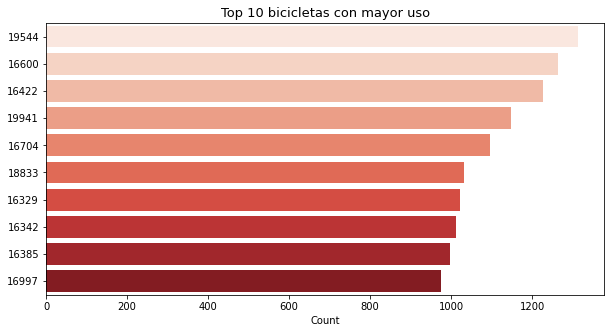

In [28]:
agrupado = dataFrame["bike_id"].value_counts()[:10]
plt.figure(figsize=(10, 5))
sns.barplot(y=agrupado.index, x=agrupado, palette="Reds")
plt.xlabel("Count")
plt.title("Top 10 bicicletas con mayor uso", size=13);

In [29]:
dataFrame["bike_id"].value_counts()[-10:]

16238           1
50587           1
15450           1
13764           1
11319           1
06495           1
Dock Block 1    1
15569           1
Rblock          1
19974           1
Name: bike_id, dtype: int64

#### Plan_duration	

En esta variable también tenemos valores nulos, analicemos el total, la proporción y si hay algun motivo

In [30]:
total_na_valores = pd.DataFrame(dataFrame[['plan_duration']].isna().sum())
total_na_porcentaje = pd.DataFrame((dataFrame[['plan_duration']].isna().sum()*100/dataFrame.shape[0]).round(3))
total_na_plan_duration = pd.concat([total_na_valores, total_na_porcentaje], axis=1)
total_na_plan_duration.columns = ["Total-Valores-Nulos", "Proporcion-Valores-Nulos"]
total_na_plan_duration

,Total-Valores-Nulos,Proporcion-Valores-Nulos
plan_duration,208,0.03


In [31]:
estadisticas_plan_duration = generar_estadisticas_basicas(dataFrame[dataFrame["plan_duration"].notna()]["plan_duration"])
estadisticas_plan_duration

,plan_duration
count,699792.000000
mean,44.928697
std,92.816296
min,0.000000
25%,1.000000
50%,30.000000
75%,30.000000
max,999.000000
skew,3.159952
kurtosis,8.881603


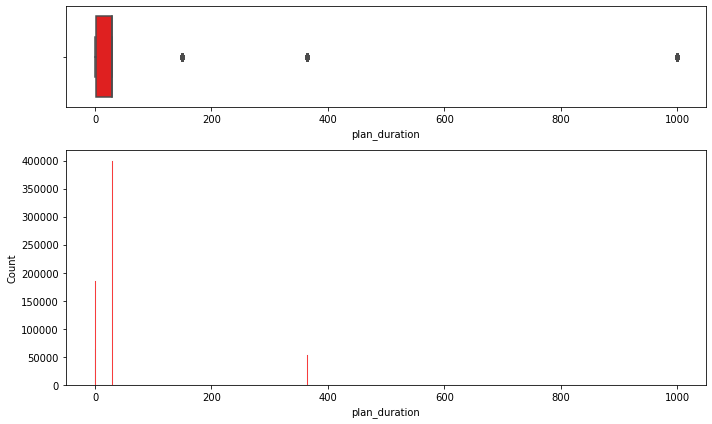

In [32]:
fig, axes = plt.subplots(2, 1, figsize=(10, 6), tight_layout=True, gridspec_kw={'height_ratios':[0.6, 1.4]})
sns.boxplot(x=dataFrame["plan_duration"], color='red', ax=axes[0])
sns.histplot(x=dataFrame["plan_duration"], color='red', ax=axes[1]);

Como podemos observar, en esta variable también tenemos un conjunto de datos atípicos. Pero como podemos ver en el histograma, tenemos una cantidad significativa de datos. <br>
Haremos el análisis para determinar el total de datos atípicos que tenemos

In [33]:
dataFrame[dataFrame["plan_duration"] > 150]["plan_duration"].shape

(52623,)

El total de datos que tenemos nos dice que no son necesariamente datos atípicos. Al final, tenemos datos con una cola pesada. Posiblemente tendremos que tranformar estos datos.

#### trip_route_category

In [34]:
total_datos_route = pd.DataFrame(dataFrame["trip_route_category"].value_counts())
total_porce_route = pd.DataFrame(dataFrame["trip_route_category"].value_counts(normalize=True)*100)
total_data_route = pd.concat([total_datos_route, total_porce_route], axis=1)
total_data_route

,trip_route_category,trip_route_category
One Way,582076,83.153714
Round Trip,117924,16.846286


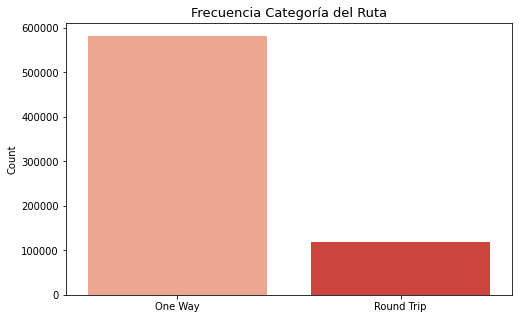

In [35]:
agrupado = dataFrame["trip_route_category"].value_counts()
plt.figure(figsize=(8, 5))
sns.barplot(x=agrupado.index, y=agrupado, palette="Reds")
plt.title("Frecuencia Categoría del Ruta", size=13)
plt.ylabel("Count");

#### passholder_type

En esta variable también nos encontramos con datos vacíos. Aunque estos no representan ni el 1% de los datos.

In [36]:
total_na_valores = pd.DataFrame(dataFrame[['passholder_type']].isna().sum())
total_na_porcentaje = pd.DataFrame((dataFrame[['passholder_type']].isna().sum()*100/dataFrame.shape[0]).round(3))
total_na_pass_type = pd.concat([total_na_valores, total_na_porcentaje], axis=1)
total_na_pass_type.columns = ["Total-Valores-Nulos", "Proporcion-Valores-Nulos"]
total_na_pass_type

,Total-Valores-Nulos,Proporcion-Valores-Nulos
passholder_type,2576,0.368


In [37]:
total_datos_pass = pd.DataFrame(dataFrame["passholder_type"].value_counts())
total_porce_pass = pd.DataFrame(dataFrame["passholder_type"].value_counts(normalize=True)*100)
total_data_pass = pd.concat([total_datos_pass, total_porce_pass], axis=1)
total_data_pass

,passholder_type,passholder_type
Monthly Pass,394769,56.603874
Walk-up,212426,30.458659
One Day Pass,44455,6.374171
Annual Pass,34092,4.888275
Flex Pass,11604,1.663837
Testing,78,0.011184


Podemos notar que tenemos un tipo de pase que no representa ni el 1% del total. Al parecer son pruebas, podríamos no considerarlo.

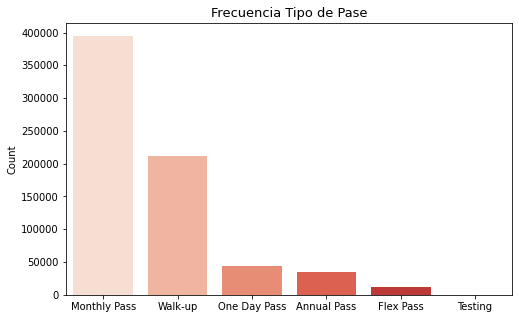

In [38]:
agrupado = dataFrame["passholder_type"].value_counts()
plt.figure(figsize=(8, 5))
sns.barplot(x=agrupado.index, y=agrupado, palette="Reds")
plt.title("Frecuencia Tipo de Pase", size=13)
plt.ylabel("Count");

#### start_station | end_station

¿Cuántas estaciones únicas tenemos?

In [39]:
dataFrame["start_station"].nunique()

364

¿Cuáles son las estaciones de inicio y fin más frecuentadas?

La estación más frecuentada tanto para el inicio como el fin es la estación 3005

In [40]:
agrupado = dataFrame["start_station"].value_counts()[:10]
agrupado

3005    28490
3030    20280
3014    18739
4214    17466
3031    17069
3035    15381
3064    14733
3082    13667
4210    13379
3042    12667
Name: start_station, dtype: int64

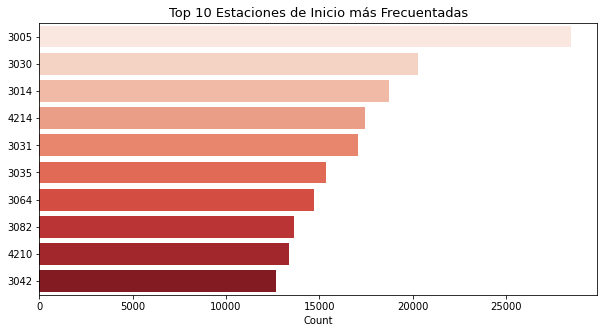

In [41]:
plt.figure(figsize=(10, 5))
sns.barplot(y=agrupado.index.astype(str), x=agrupado, palette="Reds")
plt.xlabel("Count")
plt.title("Top 10 Estaciones de Inicio más Frecuentadas", size=13);

In [42]:
agrupado = dataFrame["end_station"].value_counts()[:10]
agrupado

3005    30576
3014    20688
3031    18401
3030    17407
4215    16974
3035    15830
3082    15450
3064    15048
4214    15010
3042    14852
Name: end_station, dtype: int64

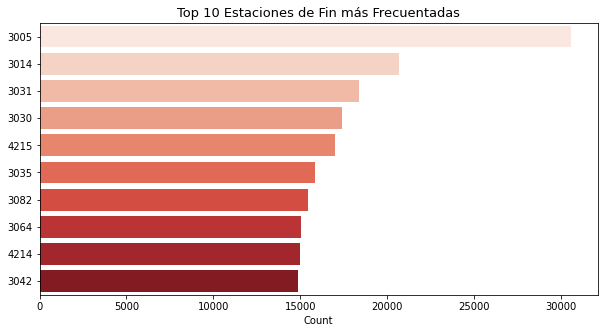

In [43]:
plt.figure(figsize=(10, 5))
sns.barplot(y=agrupado.index.astype(str), x=agrupado, palette="Reds")
plt.xlabel("Count")
plt.title("Top 10 Estaciones de Fin más Frecuentadas", size=13);

### Resolución a preguntas de interés

#### Pregunta 1
Saturación del servicio: La empresa busca contar con la disponibilidad más alta
de servicio en el mercado, por lo que se quiere entender cómo se comporta la
demanda de servicio en las distintas estaciones y horarios para cada plan

##### Monthly Pass

In [44]:
monthly_pass = dataFrame[dataFrame["passholder_type"] == "Monthly Pass"]

¿Cuáles son las 3 estaciones que frecuentan los clientes con un __Monthly Pass__?

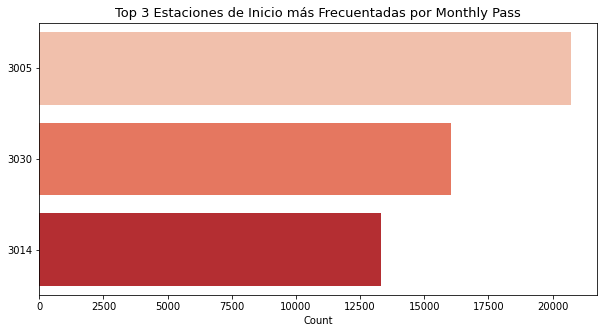

In [45]:
agrupado_mp = monthly_pass["start_station"].value_counts()[:3]
plt.figure(figsize=(10, 5))
sns.barplot(y=agrupado_mp.index.astype(str), x=agrupado_mp, palette="Reds")
plt.xlabel("Count")
plt.title("Top 3 Estaciones de Inicio más Frecuentadas por Monthly Pass", size=13);

In [46]:
monthly_pass_3005 = monthly_pass[monthly_pass["start_station"] == 3005]
monthly_pass_3030 = monthly_pass[monthly_pass["start_station"] == 3030]
monthly_pass_3014 = monthly_pass[monthly_pass["start_station"] == 3014]

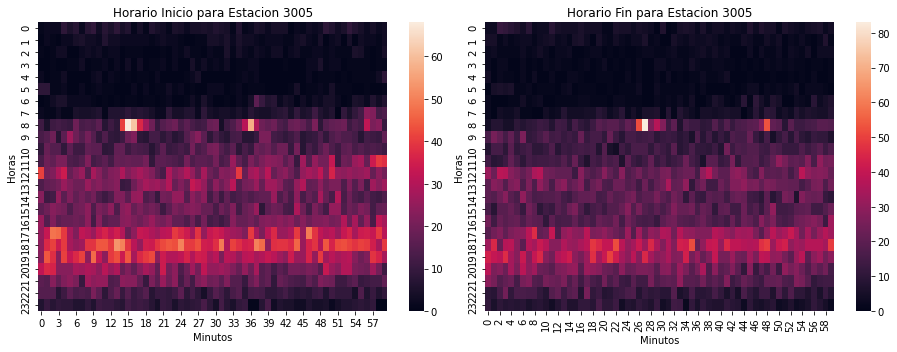

In [47]:
pivot_mp_3005_i = pd.pivot_table(data=monthly_pass_3005, values="trip_id", index="start_time_hour", columns="start_time_minute", aggfunc='count').fillna(0)
pivot_mp_3005_f = pd.pivot_table(data=monthly_pass_3005, values="trip_id", index="end_time_hour", columns="end_time_minute", aggfunc='count').fillna(0)

generar_mapa_calor_2(pivot_mp_3005_i, pivot_mp_3005_f, '3005')

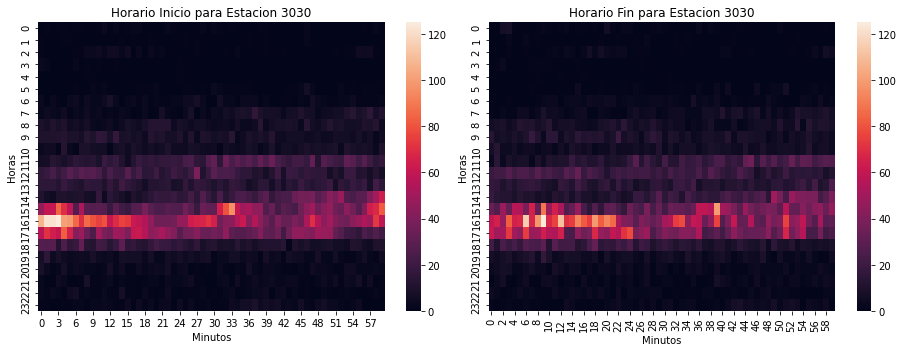

In [48]:
pivot_mp_3030_i = pd.pivot_table(data=monthly_pass_3030, values="trip_id", index="start_time_hour", columns="start_time_minute", aggfunc='count').fillna(0)
pivot_mp_3030_f = pd.pivot_table(data=monthly_pass_3030, values="trip_id", index="end_time_hour", columns="end_time_minute", aggfunc='count').fillna(0)

generar_mapa_calor_2(pivot_mp_3030_i, pivot_mp_3030_f, '3030')

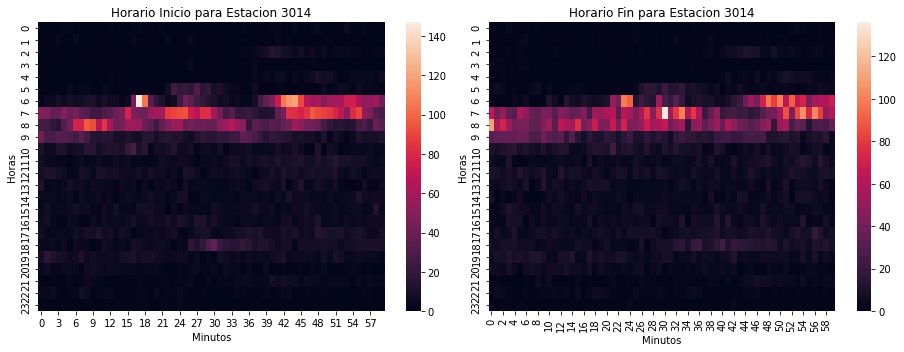

In [49]:
pivot_mp_3014_i = pd.pivot_table(data=monthly_pass_3014, values="trip_id", index="start_time_hour", columns="start_time_minute", aggfunc='count').fillna(0)
pivot_mp_3014_f = pd.pivot_table(data=monthly_pass_3014, values="trip_id", index="end_time_hour", columns="end_time_minute", aggfunc='count').fillna(0)

generar_mapa_calor_2(pivot_mp_3014_i, pivot_mp_3014_f, '3014')

##### Walk-Up

In [50]:
walk_up = dataFrame[dataFrame["passholder_type"] == "Walk-up"]

¿Cuáles son las 3 estaciones que frecuentan los clientes con un __Walk-up__?

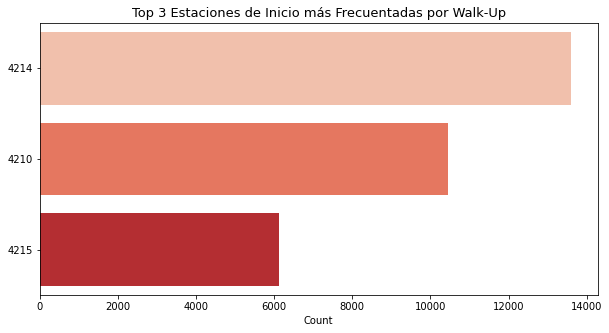

In [51]:
agrupado_wu = walk_up["start_station"].value_counts()[:3]
plt.figure(figsize=(10, 5))
sns.barplot(y=agrupado_wu.index.astype(str), x=agrupado_wu, palette="Reds")
plt.xlabel("Count")
plt.title("Top 3 Estaciones de Inicio más Frecuentadas por Walk-Up", size=13);

In [52]:
walk_up_4214 = walk_up[walk_up["start_station"] == 4214]
walk_up_4210 = walk_up[walk_up["start_station"] == 4210]
walk_up_4215 = walk_up[walk_up["start_station"] == 4215]

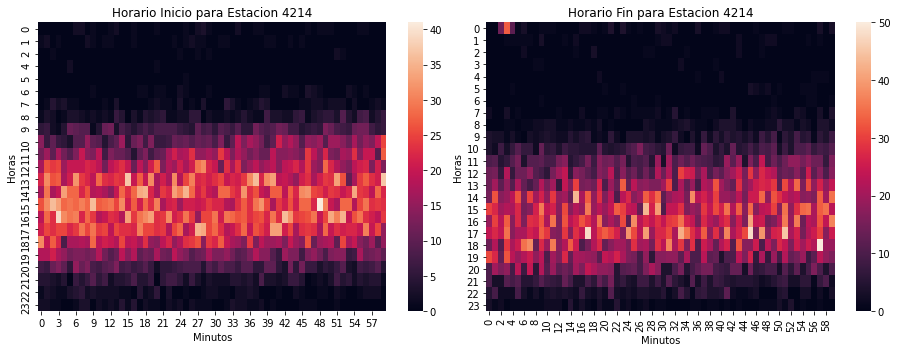

In [53]:
pivot_wu_4214_i = pd.pivot_table(data=walk_up_4214, values="trip_id", index="start_time_hour", columns="start_time_minute", aggfunc='count').fillna(0)
pivot_wu_4214_f = pd.pivot_table(data=walk_up_4214, values="trip_id", index="end_time_hour", columns="end_time_minute", aggfunc='count').fillna(0)

generar_mapa_calor_2(pivot_wu_4214_i, pivot_wu_4214_f, '4214')

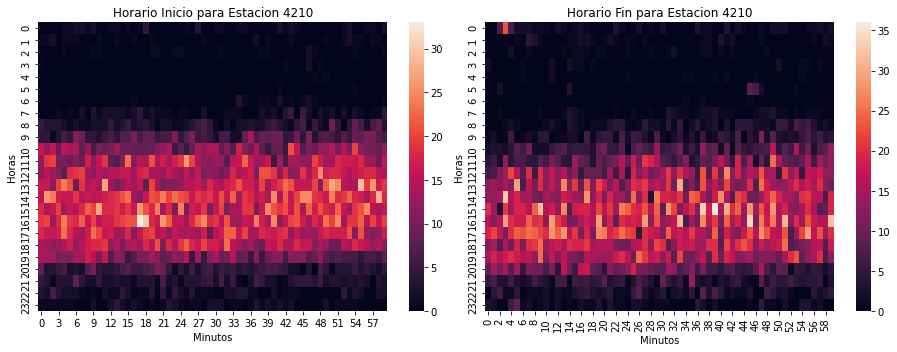

In [54]:
pivot_wu_4210_i = pd.pivot_table(data=walk_up_4210, values="trip_id", index="start_time_hour", columns="start_time_minute", aggfunc='count').fillna(0)
pivot_wu_4210_f = pd.pivot_table(data=walk_up_4210, values="trip_id", index="end_time_hour", columns="end_time_minute", aggfunc='count').fillna(0)

generar_mapa_calor_2(pivot_wu_4210_i, pivot_wu_4210_f, '4210')

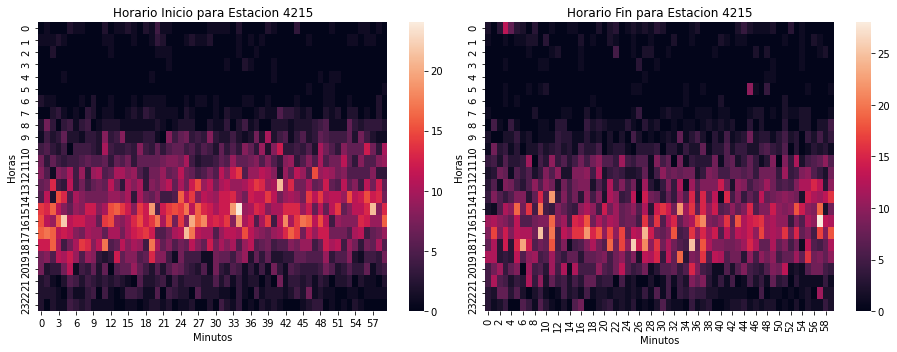

In [55]:
pivot_wu_4215_i = pd.pivot_table(data=walk_up_4215, values="trip_id", index="start_time_hour", columns="start_time_minute", aggfunc='count').fillna(0)
pivot_wu_4215_f = pd.pivot_table(data=walk_up_4215, values="trip_id", index="end_time_hour", columns="end_time_minute", aggfunc='count').fillna(0)

generar_mapa_calor_2(pivot_wu_4215_i, pivot_wu_4215_f, '4215')

##### One Day Pass

In [56]:
one_day_pass = dataFrame[dataFrame["passholder_type"] == "One Day Pass"]

¿Cuáles son las 3 estaciones que frecuentan los clientes con un __One Day Pass__?

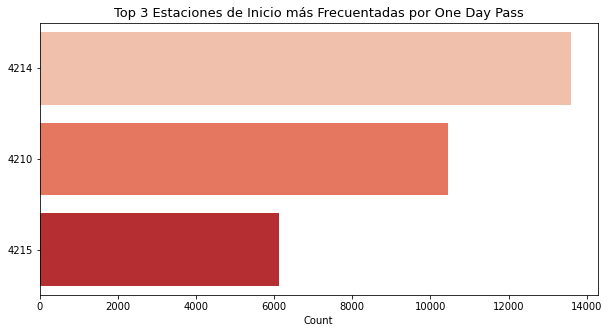

In [57]:
agrupado_odp = walk_up["start_station"].value_counts()[:3]
plt.figure(figsize=(10, 5))
sns.barplot(y=agrupado_odp.index.astype(str), x=agrupado_odp, palette="Reds")
plt.xlabel("Count")
plt.title("Top 3 Estaciones de Inicio más Frecuentadas por One Day Pass", size=13);

In [58]:
one_day_pass_4214 = one_day_pass[one_day_pass["start_station"] == 4214]
one_day_pass_4210 = one_day_pass[one_day_pass["start_station"] == 4210]
one_day_pass_4215 = one_day_pass[one_day_pass["start_station"] == 4215]

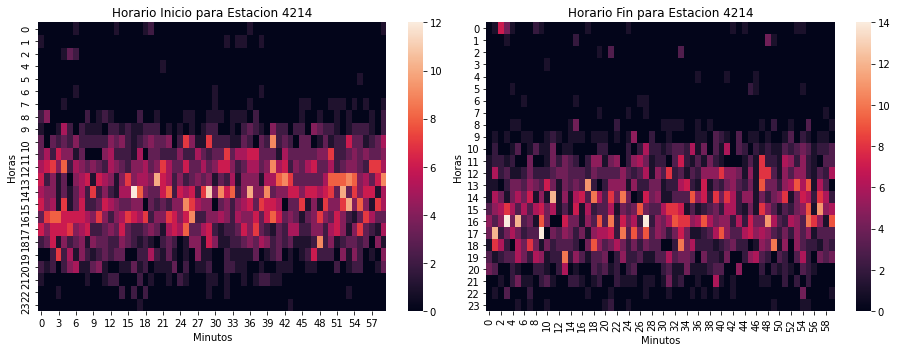

In [59]:
pivot_odp_4214_i = pd.pivot_table(data=one_day_pass_4214, values="trip_id", index="start_time_hour", columns="start_time_minute", aggfunc='count').fillna(0)
pivot_odp_4214_f = pd.pivot_table(data=one_day_pass_4214, values="trip_id", index="end_time_hour", columns="end_time_minute", aggfunc='count').fillna(0)

generar_mapa_calor_2(pivot_odp_4214_i, pivot_odp_4214_f, '4214')

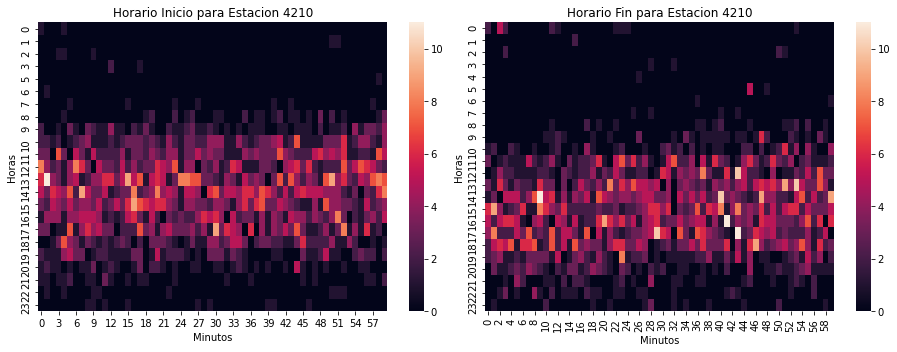

In [60]:
pivot_odp_4210_i = pd.pivot_table(data=one_day_pass_4210, values="trip_id", index="start_time_hour", columns="start_time_minute", aggfunc='count').fillna(0)
pivot_odp_4210_f = pd.pivot_table(data=one_day_pass_4210, values="trip_id", index="end_time_hour", columns="end_time_minute", aggfunc='count').fillna(0)

generar_mapa_calor_2(pivot_odp_4210_i, pivot_odp_4210_f, '4210')

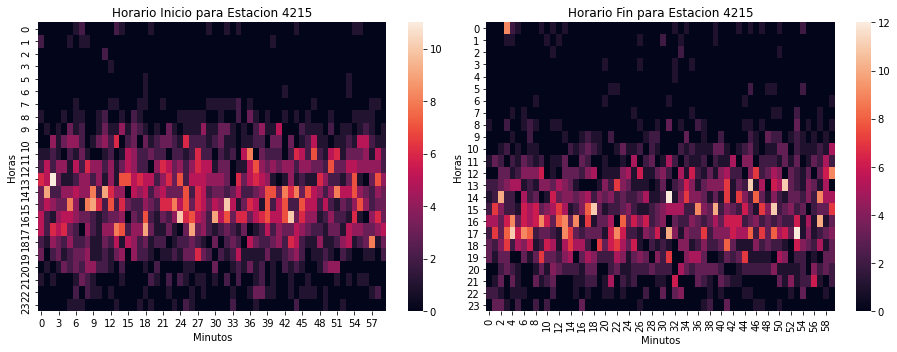

In [61]:
pivot_odp_4215_i = pd.pivot_table(data=one_day_pass_4215, values="trip_id", index="start_time_hour", columns="start_time_minute", aggfunc='count').fillna(0)
pivot_odp_4215_f = pd.pivot_table(data=one_day_pass_4215, values="trip_id", index="end_time_hour", columns="end_time_minute", aggfunc='count').fillna(0)

generar_mapa_calor_2(pivot_odp_4215_i, pivot_odp_4215_f, '4215')

##### Annual Pass

In [62]:
annual_pass = dataFrame[dataFrame["passholder_type"] == "Annual Pass"]

¿Cuáles son las 3 estaciones que frecuentan los clientes con un __Annual Pass__?

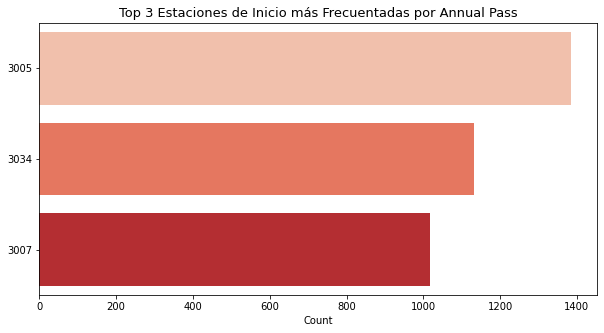

In [63]:
agrupado_ap = annual_pass["start_station"].value_counts()[:3]
plt.figure(figsize=(10, 5))
sns.barplot(y=agrupado_ap.index.astype(str), x=agrupado_ap, palette="Reds")
plt.xlabel("Count")
plt.title("Top 3 Estaciones de Inicio más Frecuentadas por Annual Pass", size=13);

In [64]:
annual_pass_3005 = annual_pass[annual_pass["start_station"] == 3005]
annual_pass_3034 = annual_pass[annual_pass["start_station"] == 3034]
annual_pass_3007 = annual_pass[annual_pass["start_station"] == 3007]

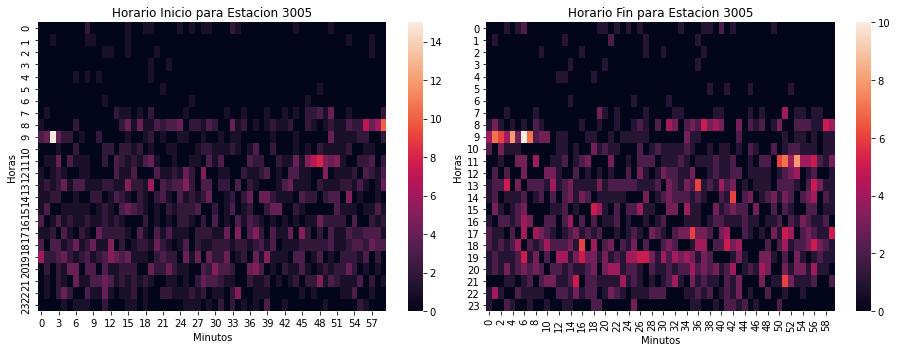

In [65]:
pivot_ap_3005_i = pd.pivot_table(data=annual_pass_3005, values="trip_id", index="start_time_hour", columns="start_time_minute", aggfunc='count').fillna(0)
pivot_ap_3005_f = pd.pivot_table(data=annual_pass_3005, values="trip_id", index="end_time_hour", columns="end_time_minute", aggfunc='count').fillna(0)

generar_mapa_calor_2(pivot_ap_3005_i, pivot_ap_3005_f, '3005')


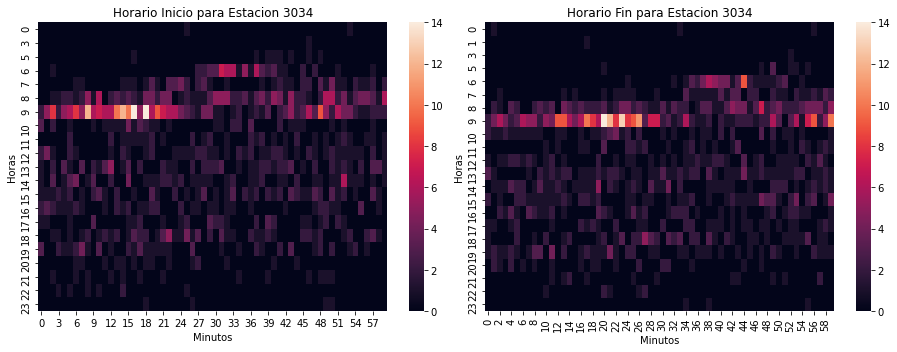

In [66]:
pivot_ap_3034_i = pd.pivot_table(data=annual_pass_3034, values="trip_id", index="start_time_hour", columns="start_time_minute", aggfunc='count').fillna(0)
pivot_ap_3034_f = pd.pivot_table(data=annual_pass_3034, values="trip_id", index="end_time_hour", columns="end_time_minute", aggfunc='count').fillna(0)

generar_mapa_calor_2(pivot_ap_3034_i, pivot_ap_3034_f, '3034')


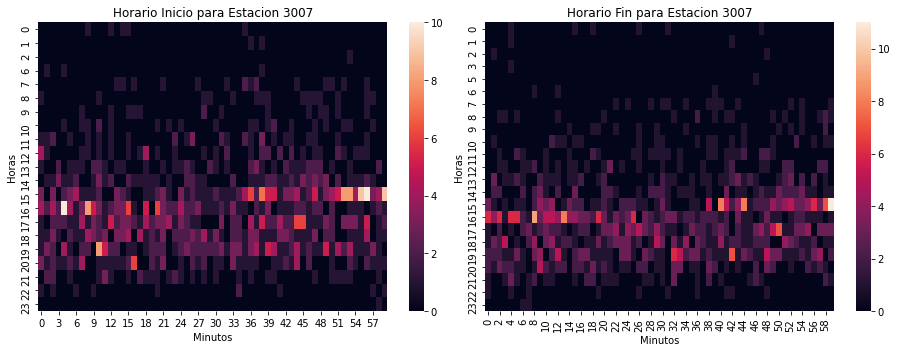

In [67]:
pivot_ap_3007_i = pd.pivot_table(data=annual_pass_3007, values="trip_id", index="start_time_hour", columns="start_time_minute", aggfunc='count').fillna(0)
pivot_ap_3007_f = pd.pivot_table(data=annual_pass_3007, values="trip_id", index="end_time_hour", columns="end_time_minute", aggfunc='count').fillna(0)
generar_mapa_calor_2(pivot_ap_3007_i, pivot_ap_3007_f, '3007')

#### Pregunta 2
Crecimiento de planes: Se tiene la intuición que la tendencia en uso de
bicicletas compartidas entre estaciones va a la alta, por lo que se requiere
realizar una correcta planificación de bicicletas que deben tener.
Adicionalmente, se espera que los planes de consumo anual crezcan en mayor
proporción.

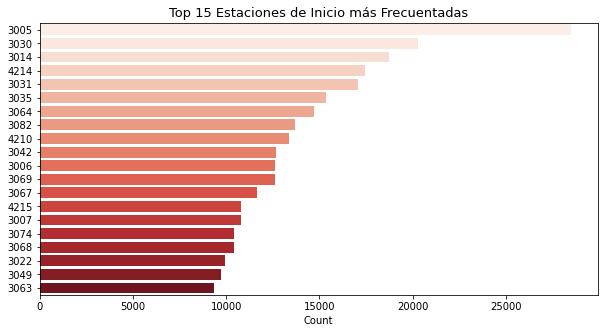

In [68]:
agrupado = dataFrame["start_station"].value_counts()[:20]
plt.figure(figsize=(10, 5))
sns.barplot(y=agrupado.index.astype(str), x=agrupado, palette="Reds")
plt.xlabel("Count")
plt.title("Top 15 Estaciones de Inicio más Frecuentadas", size=13);

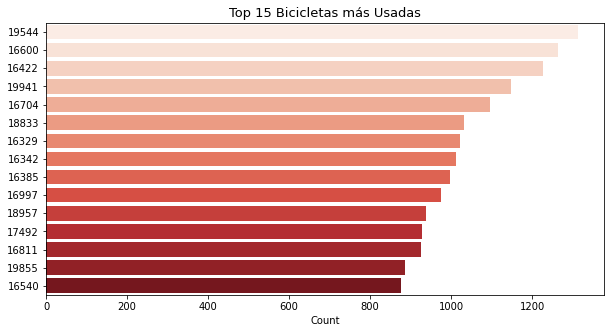

In [69]:
agrupado = dataFrame["bike_id"].value_counts()[:15]
plt.figure(figsize=(10, 5))
sns.barplot(y=agrupado.index.astype(str), x=agrupado, palette="Reds")
plt.xlabel("Count")
plt.title("Top 15 Bicicletas más Usadas", size=13);

In [70]:
# Cuales son las 20 estaciones mas frecuentas y que porcentaje de las bicicletas usan
top_20_estaciones = dataFrame['start_station'].value_counts()[:20].index
top_30_estaciones = dataFrame['start_station'].value_counts()[:30].index
top_40_estaciones = dataFrame['start_station'].value_counts()[:40].index

total_estaciones = dataFrame["start_station"].nunique()
total_bicicletas = dataFrame["bike_id"].nunique()

top_20_estaciones_data = dataFrame[dataFrame['start_station'].isin(top_20_estaciones)]
top_30_estaciones_data = dataFrame[dataFrame['start_station'].isin(top_30_estaciones)]
top_40_estaciones_data = dataFrame[dataFrame['start_station'].isin(top_40_estaciones)]

print(f"Porcentaje que ocupan las 20 estaciones más frecuentadas: {round(20*100/total_estaciones, 2)}%")
print(f"Porcentaje que ocupan las 30 estaciones más frecuentadas: {round(30*100/total_estaciones, 2)}%")
print(f"Porcentaje que ocupan las 40 estaciones más frecuentadas: {round(40*100/total_estaciones, 2)}%")

Porcentaje que ocupan las 20 estaciones más frecuentadas: 5.49%
Porcentaje que ocupan las 30 estaciones más frecuentadas: 8.24%
Porcentaje que ocupan las 40 estaciones más frecuentadas: 10.99%


¿Qué porcentaje de bicicletas ocupan las 20 estaciones más frecuentadas?

In [71]:
resultado = round(top_20_estaciones_data["bike_id"].nunique()*100/total_bicicletas, 2)
print(f"Porcentaje de bicicletas ocupadas por las 20 estaciones más frecuentadas: {resultado}%")

Porcentaje de bicicletas ocupadas por las 20 estaciones más frecuentadas: 82.32%


¿Qué porcentaje de bicicletas ocupan las 30 estaciones más frecuentadas?

In [72]:
resultado = round(top_30_estaciones_data["bike_id"].nunique()*100/total_bicicletas, 2)
print(f"Porcentaje de bicicletas ocupadas por las 30 estaciones más frecuentadas: {resultado}%")

Porcentaje de bicicletas ocupadas por las 30 estaciones más frecuentadas: 82.39%


¿Qué porcentaje de bicicletas ocupan las 40 estaciones más frecuentadas?

In [73]:
resultado = round(top_40_estaciones_data["bike_id"].nunique()*100/total_bicicletas, 2)
print(f"Porcentaje de bicicletas ocupadas por las 40 estaciones más frecuentadas: {resultado}%")

Porcentaje de bicicletas ocupadas por las 40 estaciones más frecuentadas: 82.48%


¿Qué porcentaje de viajes ocurre en las 20 estaciones más frecuentadas?

In [74]:
total_viajes = top_20_estaciones_data.shape[0]
resultado = round(total_viajes*100/dataFrame.shape[0], 2)
print(f"Porcentaje de viajes por las 20 estaciones más frecuentadas: {resultado}%")

Porcentaje de viajes por las 20 estaciones más frecuentadas: 40.03%


¿Qué porcentaje de viajes ocurre en las 30 estaciones más frecuentadas?

In [75]:
total_viajes = top_30_estaciones_data.shape[0]
resultado = round(total_viajes*100/dataFrame.shape[0], 2)
print(f"Porcentaje de viajes por las 30 estaciones más frecuentadas: {resultado}%")

Porcentaje de viajes por las 30 estaciones más frecuentadas: 51.96%


¿Qué porcentaje de viajes ocurre en las 40 estaciones más frecuentadas?

In [76]:
total_viajes = top_40_estaciones_data.shape[0]
resultado = round(total_viajes*100/dataFrame.shape[0], 2)
print(f"Porcentaje de viajes por las 40 estaciones más frecuentadas: {resultado}%")

Porcentaje de viajes por las 40 estaciones más frecuentadas: 60.52%


In [97]:
coordenadas = dataFrame.groupby("start_station").agg({"start_lat":"min", "start_lon":"min", "trip_id":"count"}).reset_index().sort_values("trip_id", ascending=False)
coordenadas["color"] = "Others"
coordenadas.loc[coordenadas["start_station"].isin(top_20_estaciones), "color"] = 'Top 20'

In [98]:
import plotly.express as px

fig = px.scatter_geo(
        coordenadas,
        lat='start_lat',
        lon='start_lon', 
        hover_name="start_station",
        size="trip_id",
        color="color",
        labels="color"
)
fig.update_layout(title = 'World map', title_x=0.5)
fig.show()

In [104]:
print(dataFrame[dataFrame["start_station"] == 4215][["start_lat", "start_lon"]].min())
print(dataFrame[dataFrame["start_station"] == 4215][["start_lat", "start_lon"]].max())

start_lat     34.014309
start_lon   -118.491341
dtype: float64
start_lat     34.014309
start_lon   -118.491340
dtype: float64


In [105]:
print(dataFrame[dataFrame["start_station"] == 4344][["start_lat", "start_lon"]].min())
print(dataFrame[dataFrame["start_station"] == 4344][["start_lat", "start_lon"]].max())

start_lat     34.014309
start_lon   -118.491341
dtype: float64
start_lat     34.014309
start_lon   -118.491341
dtype: float64
